<a href="https://colab.research.google.com/github/chisomrutherford/malaria-diagnosis-with-cnn/blob/main/Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, roc_auc_score,  classification_report, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
import warnings
warnings.simplefilter(action='ignore')
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import KFold
sns.set()
plt.style.use("ggplot")
%matplotlib inline

In [ ]:
#import the data

df= pd.read_csv("diabetes.csv")
df.head()

In [ ]:
df.info()

In [ ]:
df.columns

In [ ]:
df.describe()

In [ ]:
df.shape
#768 rows, 9 columns

In [ ]:
df['Outcome'].value_counts()*100/len(df)

In [ ]:
#histogram of the age variable

plt.figure (figsize =(6, 4))
plt.xlabel ('Age', fontsize= 10)
plt.ylabel ('Count', fontsize= 10)
df['Age'].hist(edgecolor= "Black")

In [ ]:
df['Age'].min()

In [ ]:
print ("Maximum age is: ", str(df['Age'].max()))
print ("Minimum age is: ", str(df["Age"].min()))

In [ ]:
##density graph

plt, ax= plt.subplots (4, 2, figsize = (20, 20))

sns.distplot (df.Pregnancies, ax= ax[0, 0], color= 'red')
sns.distplot (df.Glucose, ax= ax[0, 1], color= 'red')
sns.distplot (df.BloodPressure, ax= ax[1,0], color= 'red')
sns.distplot (df.SkinThickness, ax= ax[1, 1], color= 'red')
sns.distplot (df.Insulin, ax= ax[2, 0], color= 'red')
sns.distplot (df.BMI, ax= ax[2, 1], color= 'red')
sns.distplot (df.DiabetesPedigreeFunction, ax= ax[3,0], color= 'red')
sns.distplot (df.Age, ax= ax[3, 1], color= 'red')


In [ ]:
df.columns

In [ ]:
df.groupby('Outcome').agg({'Pregnancies': 'mean'})
df.groupby('Outcome').agg({'Glucose': 'mean'})
df.groupby('Outcome').agg({'Age': 'median'})
df.groupby('Outcome').agg({'Insulin': 'median'})

In [ ]:
df.corr()

In [ ]:
#fig, ax= plt.subplots (4, 2, figsize = (20, 20))

In [ ]:
#Data Preprocessing

df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']] = df[['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age']].replace(0, np.NaN)

In [ ]:
df.isnull().sum()

In [ ]:
df.head()

In [ ]:
import missingno as msno

msno.bar (df, color= "maroon")



In [ ]:
#fill missing values with median


def median_target(var):
  temp= df[df[var].notnull()]
  temp= temp[[var, 'Outcome']].groupby(['Outcome'])[[var]].median().reset_index()
  return temp



In [ ]:
columns= df.columns
columns = columns.drop('Outcome')
for i in columns:
  median_target(i)
  df.loc[(df['Outcome']==0 & (df[i].isnull()), i)]= median_target(i)[i][0]
  df.loc[(df['Outcome']==1 & (df[i].isnull()), i)]= median_target(i)[i][1]

In [ ]:
df.head()

In [ ]:
df.isnull().sum()

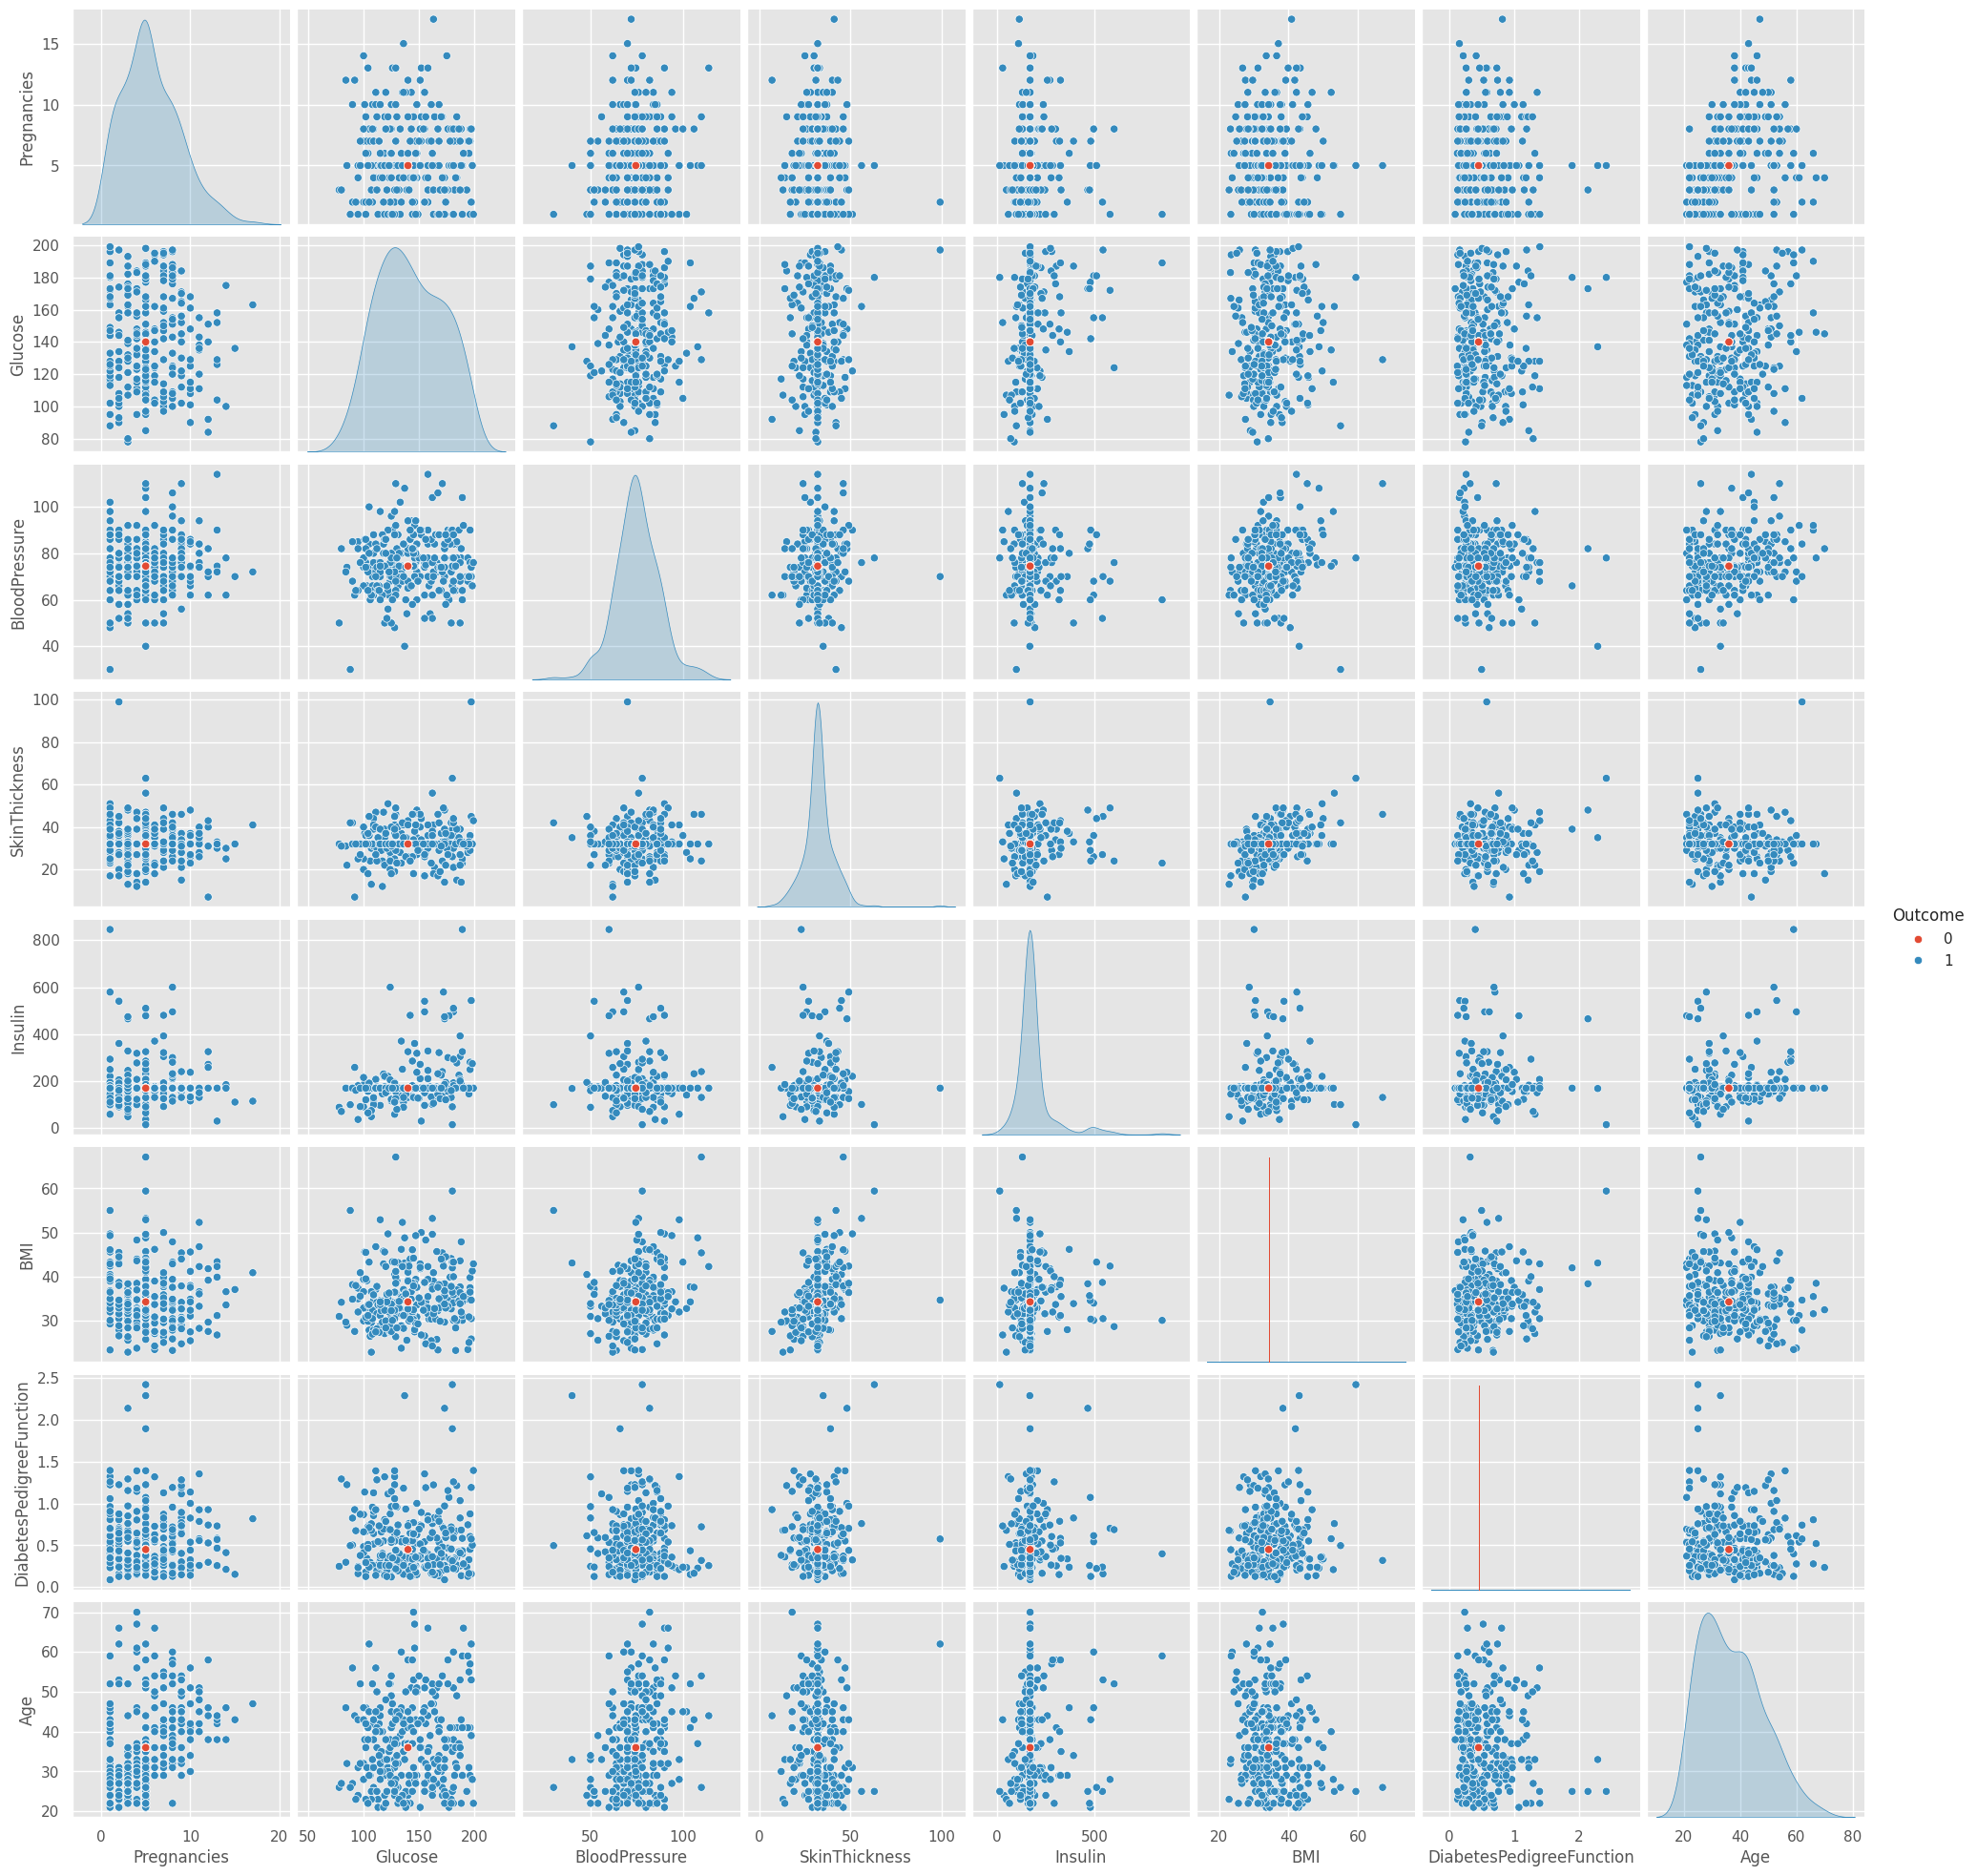

In [ ]:
#pairplot
sns.pairplot(df, hue='Outcome')

In [ ]:
#outlierdetection

for feature in df:
  Q1= df[feature].quantile(0.25)
  Q3= df[feature].quantile(0.75)
  IQR= Q3-Q1
  upper= Q3+1.5*IQR
  lower= Q1-1.5*IQR
  if df[(df[feature]>upper)].any(axis= None):
    print (feature, ':Outlier exists')
  else:
    print (feature, ':Outlier does not exist')






Pregnancies :Outlier exists
Glucose :Outlier exists
BloodPressure :Outlier exists
SkinThickness :Outlier exists
Insulin :Outlier exists
BMI :Outlier exists
DiabetesPedigreeFunction :Outlier exists
Age :Outlier exists
Outcome :Outlier does not exist


In [ ]:
#Remove outliers
Q1= df.Insulin.quantile(0.25)
Q3= df.Insulin.quantile(0.75)
IQR= Q3-Q1
upper= Q3+1.5*IQR
lower= Q1-1.5*IQR

df.loc[df['Insulin']>upper, "Insulin"]= upper




In [ ]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome'],
      dtype='object')

In [ ]:
Q1= df.Glucose.quantile(0.25)
Q3= df.Glucose.quantile(0.75)
IQR= Q3-Q1
upper= Q3+1.5*IQR
lower= Q1-1.5*IQR

df.loc[df['Glucose']> upper, "Glucose"]= upper

In [ ]:
Q1= df.BloodPressure.quantile(0.25)
Q3= df.BloodPressure.quantile(0.75)
IQR= Q3-Q1
upper= Q3+1.5*IQR
lower= Q1-1.5*IQR
df.loc[df['BloodPressure']>lower, 'BloodPressure']= lower

In [ ]:
#local outlier factor(LOF)
from sklearn.neighbors import LocalOutlierFactor
lof= LocalOutlierFactor(n_neighbors= 10)
lof.fit_predict(df)





array([ 1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1, -1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1, -1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  1,  1,  1

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,140.0,72.0,35.0,169.5,33.6,0.627,50,1
1,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0
2,8.0,140.0,64.0,32.0,169.5,23.3,0.672,32,1
3,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1


In [ ]:

df_scores = lof.negative_outlier_factor_
np.sort(df_scores)[0:20]

array([-5.77364246e+10, -5.44404109e+10, -5.22767542e+10, -4.66671928e+10,
       -4.40598448e+10, -4.12076107e+10, -3.94668531e+10, -3.87336818e+10,
       -3.80436586e+10, -3.75304660e+10, -3.60318405e+10, -3.19355855e+10,
       -2.10341279e+10, -2.07973715e+10, -1.40765851e+10, -3.95216372e+00,
       -1.87817407e+00, -1.83353658e+00, -1.67561796e+00, -1.63111252e+00])

In [ ]:
threshold= np.sort(df_scores)[7]

In [ ]:
threshold

-38733681814.66048

In [ ]:
outlier= df_scores>threshold

In [ ]:
outlier

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
df= df[outlier]

In [ ]:
df

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6.0,140.0,72.0,35.0,169.5,33.6,0.627,50,1
1,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0
2,8.0,140.0,64.0,32.0,169.5,23.3,0.672,32,1
3,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0
764,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0
765,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0
766,1.0,126.0,60.0,32.0,169.5,30.1,0.349,47,1


Feature Engineering


In [ ]:
NewBMI = pd.Series(["Underweight", "Normal", "Overweight", "Obesity 1", "Obesity 2", "Obesity 3"], dtype = "category")




In [ ]:
NewBMI

,0
0,Underweight
1,Normal
2,Overweight
3,Obesity 1
4,Obesity 2
5,Obesity 3


In [ ]:
df["NewBMI"]= NewBMI

df.loc[(df["BMI"]< 18.5, "NewBMI")]= NewBMI[0]
df.loc[((df["BMI"]>18.5) & (df["BMI"]<=24.9)) , "NewBMI"]= NewBMI[1]
df.loc[(df["BMI"]>=25) & (df["BMI"]<= 29.9), "NewBMI"]= NewBMI[2]
df.loc[(df["BMI"]>=30) & (df["BMI"]<= 34.9), "NewBMI"]= NewBMI[3]
df.loc[(df["BMI"]>34.9) & (df["BMI"]<= 39.9), "NewBMI"]= NewBMI[4]
df.loc[(df["BMI"]>= 40), "NewBMI"]= NewBMI[5]

#df["NewBMI"] = df["NewBMI"].astype(int)

In [ ]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI
0,6.0,140.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1
1,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,Obesity 1
2,8.0,140.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal
3,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,Obesity 1
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity 3
5,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,Obesity 1
6,3.0,78.0,50.0,32.0,88.0,31.0,0.248,26,1,Obesity 1
7,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,Obesity 1
8,2.0,140.0,70.0,45.0,169.5,30.5,0.158,53,1,Obesity 1
9,8.0,125.0,74.5,32.0,169.5,34.3,0.232,54,1,Obesity 1


In [ ]:
#if insulin >= 16 & insulin <= 166 --> norml otherwise abnormal

def set_insulin(row):
  if row["Insulin"] >= 16 and row["Insulin"]<= 166:
    return "Normal"
  else:
    return "Abnormal"



In [ ]:
df= df.assign (NewInsulinScore= df.apply(set_insulin, axis= 1))

In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore
0,6.0,140.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1,Abnormal
1,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,Obesity 1,Abnormal
2,8.0,140.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal,Abnormal
3,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,Obesity 1,Abnormal
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity 3,Abnormal


In [ ]:
NewGlucose = pd.Series (["Low", "Normal", "Secret", "High"], dtype= "category")

df["NewGlucose"]= NewGlucose

df.loc[df["Glucose"]<= 70, "NewGlucose"]= NewGlucose[0]
df.loc[(df["Glucose"]> 70) & (df["Glucose"]<= 99), "NewGlucose"]= NewGlucose[1]
df.loc[(df["Glucose"]> 99) & (df["Glucose"]<= 126), "NewGlucose"]= NewGlucose[2]
df.loc[df["Glucose"]> 126, "NewGlucose"]= NewGlucose[0]



In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore,NewGlucose
0,6.0,140.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1,Abnormal,Low
1,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,Obesity 1,Abnormal,Low
2,8.0,140.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal,Abnormal,Low
3,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,Obesity 1,Abnormal,Low
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity 3,Abnormal,Low


In [ ]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI,NewInsulinScore,NewGlucose
0,6.0,140.0,72.0,35.0,169.5,33.6,0.627,50,1,Obesity 1,Abnormal,Low
1,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,Obesity 1,Abnormal,Low
2,8.0,140.0,64.0,32.0,169.5,23.3,0.672,32,1,Normal,Abnormal,Low
3,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,Obesity 1,Abnormal,Low
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,Obesity 3,Abnormal,Low
5,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,Obesity 1,Abnormal,Low
6,3.0,78.0,50.0,32.0,88.0,31.0,0.248,26,1,Obesity 1,Normal,Normal
7,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,Obesity 1,Abnormal,Low
8,2.0,140.0,70.0,45.0,169.5,30.5,0.158,53,1,Obesity 1,Abnormal,Low
9,8.0,125.0,74.5,32.0,169.5,34.3,0.232,54,1,Obesity 1,Abnormal,Secret


In [ ]:
#handling categorical features

df= pd.get_dummies(df, columns= ["NewBMI", "NewInsulinScore", "NewGlucose"], drop_first= True)


#df= df.get_dummies(df, columns= ['NewBMI', 'NewInsulinScore', 'NewGlucose'], drop_first= True#)


In [ ]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Secret
0,6.0,140.0,72.0,35.0,169.5,33.6,0.627,50,1,True,False,False,False,False,False,True,False,False
1,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,True,False,False,False,False,False,True,False,False
2,8.0,140.0,64.0,32.0,169.5,23.3,0.672,32,1,False,False,False,False,False,False,True,False,False
3,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36,0,True,False,False,False,False,False,True,False,False
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33,1,False,False,True,False,False,False,True,False,False


In [ ]:
df.columns

Index(['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
       'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome', 'NewBMI_Obesity 1',
       'NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight',
       'NewBMI_Underweight', 'NewInsulinScore_Normal', 'NewGlucose_Low',
       'NewGlucose_Normal', 'NewGlucose_Secret'],
      dtype='object')

In [ ]:
categorical_df =df[['NewBMI_Obesity 1',
       'NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight',
       'NewBMI_Underweight', 'NewInsulinScore_Normal', 'NewGlucose_Low',
       'NewGlucose_Normal', 'NewGlucose_Secret']]

In [ ]:
categorical_df.head()

,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Secret
0,True,False,False,False,False,False,True,False,False
1,True,False,False,False,False,False,True,False,False
2,False,False,False,False,False,False,True,False,False
3,True,False,False,False,False,False,True,False,False
4,False,False,True,False,False,False,True,False,False


In [ ]:
y= df['Outcome']
x= df.drop(['Outcome', 'NewBMI_Obesity 1',
       'NewBMI_Obesity 2', 'NewBMI_Obesity 3', 'NewBMI_Overweight',
       'NewBMI_Underweight', 'NewInsulinScore_Normal', 'NewGlucose_Low',
       'NewGlucose_Normal', 'NewGlucose_Secret'], axis= 1)

In [ ]:
cols= x.columns
index= x.index

In [ ]:
x.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6.0,140.0,72.0,35.0,169.5,33.6,0.627,50
1,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36
2,8.0,140.0,64.0,32.0,169.5,23.3,0.672,32
3,5.0,140.0,74.5,32.0,169.5,34.3,0.449,36
4,5.0,137.0,40.0,35.0,168.0,43.1,2.288,33


In [ ]:
from sklearn.preprocessing import RobustScaler
transformer= RobustScaler().fit(x)
x= transformer.transform(x)
x= pd.DataFrame(x, columns= cols, index= index)



In [ ]:
x.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,1.0,0.0,-2.5,3.0,0.0,-0.7,0.178,14.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
2,3.0,0.0,-10.5,0.0,0.0,-11.0,0.223,-4.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0
4,0.0,-3.0,-34.5,3.0,-1.5,8.8,1.839,-3.0


In [ ]:
pd.concat ([x, categorical_df], axis= 1)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,NewBMI_Obesity 1,NewBMI_Obesity 2,NewBMI_Obesity 3,NewBMI_Overweight,NewBMI_Underweight,NewInsulinScore_Normal,NewGlucose_Low,NewGlucose_Normal,NewGlucose_Secret
0,1.0,0.0,-2.5,3.0,0.0,-0.7,0.178,14.0,True,False,False,False,False,False,True,False,False
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,True,False,False,False,False,False,True,False,False
2,3.0,0.0,-10.5,0.0,0.0,-11.0,0.223,-4.0,False,False,False,False,False,False,True,False,False
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,True,False,False,False,False,False,True,False,False
4,0.0,-3.0,-34.5,3.0,-1.5,8.8,1.839,-3.0,False,False,True,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,True,False,False,False,False,False,True,False,False
764,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,True,False,False,False,False,False,True,False,False
765,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.0,True,False,False,False,False,False,True,False,False
766,-4.0,-14.0,-14.5,0.0,0.0,-4.2,-0.100,11.0,True,False,False,False,False,False,False,False,True


In [ ]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size= 0.2, random_state= 0)

In [ ]:
scaler= StandardScaler()
x_train= scaler.fit_transform(x_train)
x_test= scaler.transform(x_test)


In [ ]:
log_reg= LogisticRegression()
log_reg.fit(x_train, y_train)

LogisticRegression()

In [ ]:
y_pred= log_reg.predict(x_test)


In [ ]:
accuracy_score(y_train, log_reg.predict(x_train))


0.9407894736842105

In [ ]:
accuracy_score(y_test, log_reg.predict(x_test))

0.9407894736842105

In [ ]:
confusion_matrix(y_test, y_pred)

array([[101,   0],
       [  9,  42]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      1.00      0.96       101
           1       1.00      0.82      0.90        51

    accuracy                           0.94       152
   macro avg       0.96      0.91      0.93       152
weighted avg       0.95      0.94      0.94       152



In [ ]:
#KNN

knn= KNeighborsClassifier()
knn.fit(x_train, y_train)

y_pred= knn.predict(x_test)

In [ ]:
accuracy_score(y_train, knn.predict(x_train))


0.9967105263157895

In [ ]:
accuracy_score(y_test, knn.predict(x_test))


1.0

In [ ]:
confusion_matrix(y_test, y_pred)

array([[101,   0],
       [  0,  51]])

In [ ]:
#svm

svc= SVC(probability=True)

parameter= {
    "gamma": [0.0001, 0.001, 0.01, 0.1],
    'C': [0.01, 0.05, 0.5, 0.01, 1, 10, 15, 20]
}

grid_search= GridSearchCV(svc, parameter)
grid_search.fit(x_train, y_train)

GridSearchCV(estimator=SVC(probability=True),
             param_grid={'C': [0.01, 0.05, 0.5, 0.01, 1, 10, 15, 20],
                         'gamma': [0.0001, 0.001, 0.01, 0.1]})

In [ ]:
grid_search.best_params_

{'C': 1, 'gamma': 0.1}

In [ ]:
grid_search.best_score_

1.0

In [ ]:
#Decision Tree

dt= DecisionTreeClassifier()
dt.fit(x_train, y_train)
y_pred= dt.predict(x_test)
